# Generalized OT Geodesics (2D Demo)

Constrained path optimization with L-BFGS, gamma scheduling, and interactive interpolation visualization.

In [1]:
import os
import sys
import importlib
from pathlib import Path

# Local path or Colab path support
repo_root = Path.cwd().resolve().parent if Path.cwd().name == 'example' else Path.cwd().resolve()

if 'google.colab' in sys.modules:
    try:
        from subprocess import run
        colab_repo = Path('/content/generalized-ot-geodesics')
        if not (colab_repo / 'ot_geodesics').exists():
            run([
                'git', 'clone',
                'https://github.com/gpeyre/generalized-ot-geodesics.git',
                str(colab_repo),
            ], check=False)
        if (colab_repo / 'ot_geodesics').exists():
            repo_root = colab_repo
        try:
            import ot  # type: ignore
        except Exception:
            run([sys.executable, '-m', 'pip', 'install', '-q', 'POT'], check=False)
            import ot  # type: ignore
    except Exception as e:
        print('Colab repo setup skipped:', e)

if (repo_root / 'ot_geodesics').exists() and str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

if not (repo_root / 'ressources').exists() and (Path('/content/generalized-ot-geodesics') / 'ressources').exists():
    repo_root = Path('/content/generalized-ot-geodesics')

import matplotlib.pyplot as plt
import numpy as np
import torch

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

import ot_geodesics.solver as solver_mod
importlib.reload(solver_mod)
GeneralizedOTGeodesicSolver = solver_mod.GeneralizedOTGeodesicSolver
optimize_with_gamma_schedule = solver_mod.optimize_with_gamma_schedule

import ot_geodesics.helper as helper_mod
importlib.reload(helper_mod)
draw_trajectories = helper_mod.draw_trajectories
compute_global_bbox = helper_mod.compute_global_bbox
plot_interpolation_time_slice = helper_mod.plot_interpolation_time_slice
make_separated_shape_clouds = helper_mod.make_separated_shape_clouds

try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    widgets = None
    display = None

print('Solver loaded from:', solver_mod.__file__)

torch.manual_seed(12)
np.random.seed(12)


Solver loaded from: /Users/gpeyre/Dropbox/github/generalized-ot-geodesics/ot_geodesics/solver.py


In [6]:
d, n = 2, 200
t_steps = 12
beta = 1.0

res_dir = repo_root / 'ressources'
if not res_dir.exists():
    raise FileNotFoundError(f'Resource directory not found: {res_dir}. repo_root={repo_root}')

x0, x1 = make_separated_shape_clouds(
    resources_dir=res_dir,
    source_name='trefle.jpg',
    target_name='cat.png',
    n_samples=n,
    offset=2.8,
    threshold=0.5,
    dtype=torch.float64,
)

x_init = x0.unsqueeze(2).repeat(1, 1, t_steps)


## Sampled Source/Target Clouds

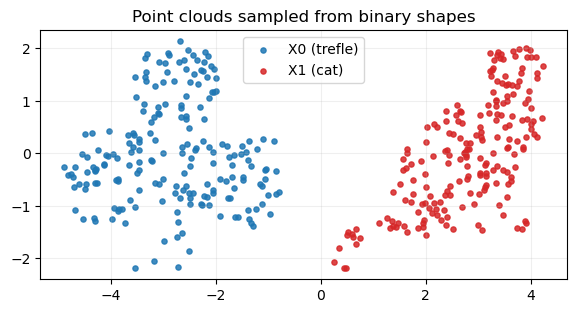

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6.8, 5.6))
ax.scatter(x0[0].numpy(), x0[1].numpy(), s=14, c='tab:blue', alpha=0.85, label='X0 (trefle)')
ax.scatter(x1[0].numpy(), x1[1].numpy(), s=14, c='tab:red', alpha=0.85, label='X1 (cat)')
ax.set_aspect('equal')
ax.grid(alpha=0.2)
ax.legend()
ax.set_title('Point clouds sampled from binary shapes')
plt.show()


## 1) Single L-BFGS Run

CUDA not detected; using CPU.
Solver compute device: cpu


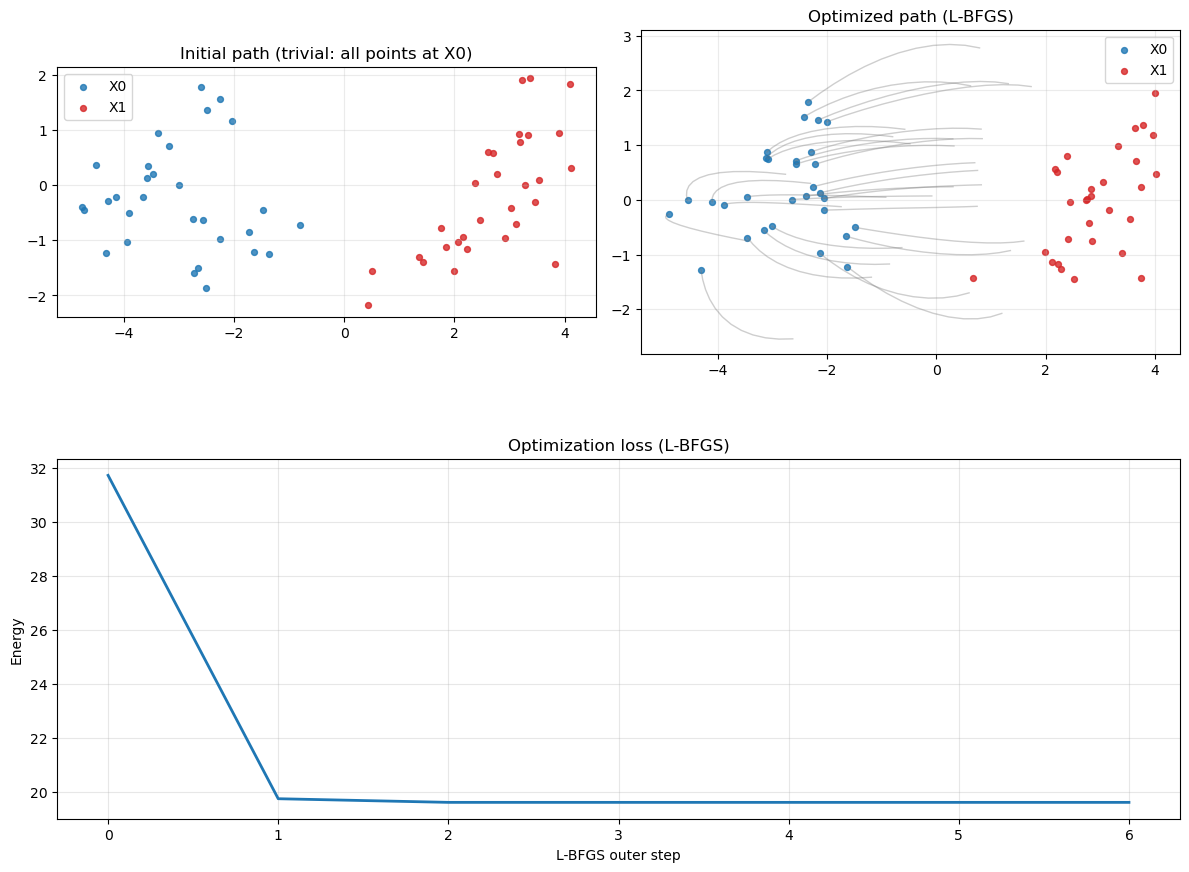

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('CUDA detected:', torch.cuda.get_device_name(0))
else:
    print('CUDA not detected; using CPU.')

solver = GeneralizedOTGeodesicSolver(
    gamma=0.1/5,
    phi_mode='transformer',
    beta=beta,
    optimizer_mode='lbfgs',
    lbfgs_lr=1.0,
    lbfgs_max_iter=20,
    device=device,
    dtype=torch.float64,
)
print('Solver compute device:', solver.device)
if device == 'cuda':
    probe = solver.initialize_path(
        x0.to(device=solver.device, dtype=solver.dtype),
        x1.to(device=solver.device, dtype=solver.dtype),
        t_steps=t_steps,
    )
    print('Initialization tensor device:', probe.device)


result = solver.optimize(
    x0, x1,
    t_steps=t_steps,
    initial_path=x_init,
    max_iter=60,
    tolerance=1e-8,
    snapshot_every=60,
)
result.losses[-1]

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[2.0, 1.2])
ax_left = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[0, 1])
ax_bottom = fig.add_subplot(gs[1, :])

draw_trajectories(
    x_init, x0, x1,
    title='Initial path (trivial: all points at X0)',
    ax=ax_left,
    show=False,
    show_legend=True,
    n_max=30,
    show_intermediate_dots=False,
)
draw_trajectories(
    result.path, x0, x1,
    title='Optimized path (L-BFGS)',
    ax=ax_right,
    show=False,
    show_legend=True,
    n_max=30,
    show_intermediate_dots=False,
)

ax_bottom.plot(result.losses, lw=2)
ax_bottom.set_title('Optimization loss (L-BFGS)')
ax_bottom.set_xlabel('L-BFGS outer step')
ax_bottom.set_ylabel('Energy')
ax_bottom.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 2) Iterative L-BFGS With Gamma Schedule

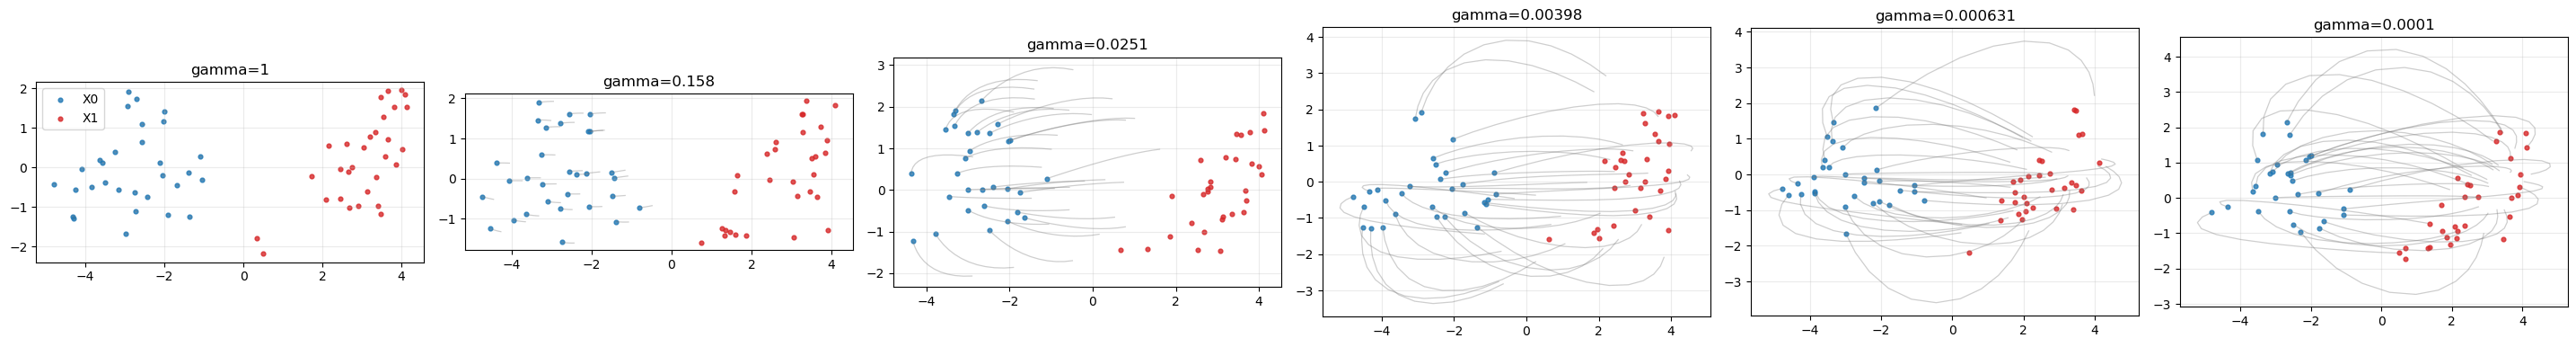

In [9]:
gammas = np.geomspace(1.0, 1e-4, 6)
scheduled_results = optimize_with_gamma_schedule(
    x0=x0,
    x1=x1,
    gammas=gammas,
    t_steps=t_steps,
    max_iter=40,
    tolerance=1e-8,
    snapshot_every=40,
    initial_path=x_init,
    phi_mode='transformer',
    beta=beta,
    optimizer_mode='lbfgs',
    lbfgs_lr=1.0,
    lbfgs_max_iter=20,
    dtype=torch.float64,
)

scheduled_paths = [res.path for res in scheduled_results]
scheduled_losses = [res.losses[-1] for res in scheduled_results]

fig, axes = plt.subplots(1, len(gammas), figsize=(4.8 * len(gammas), 4.4), squeeze=False)
for k, (g, pth) in enumerate(zip(gammas, scheduled_paths)):
    draw_trajectories(
        pth,
        x0,
        x1,
        title=f'gamma={g:.3g}',
        ax=axes[0, k],
        show=False,
        show_legend=(k == 0),
        n_max=30,
        show_intermediate_dots=False,
        endpoint_size=12,
        line_width=0.9,
    )
plt.tight_layout()
plt.show()


## 3) Interactive Interpolation Slider

In [10]:
path_for_slider = scheduled_paths[-1] if len(scheduled_paths) > 0 else result.path
T = path_for_slider.shape[2]
bbox = compute_global_bbox(path_for_slider, pad_ratio=0.08)

def show_time_slice(t=0):
    plot_interpolation_time_slice(path_for_slider, x0, x1, t=t, bbox=bbox, show=True)

if widgets is None:
    print('ipywidgets not available. Showing t=0 only.')
    show_time_slice(0)
else:
    slider = widgets.IntSlider(value=0, min=0, max=T-1, step=1, description='t')
    out = widgets.interactive_output(show_time_slice, {'t': slider})
    display(slider, out)


IntSlider(value=0, description='t', max=11)

Output()